In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric/Time_series_analysis_and_forecast_DATASET.csv


In [37]:
elect_df = pd.read_csv("/kaggle/input/electric/Time_series_analysis_and_forecast_DATASET.csv")
elect_df.FullDate = pd.to_datetime(elect_df.FullDate)
elect_df.set_index('FullDate', inplace=True)
elect_df.head()

Tmax   SysLoad  GasPrice  ElecPrice
FullDate                                                
2010-09-01 00:00:00  15.8  1688.215      3.69     23.710
2010-09-01 01:00:00  15.8  1669.195      3.69     22.635
2010-09-01 02:00:00  15.8  1491.980      3.69     22.565
2010-09-01 03:00:00  15.8  1330.760      3.69     18.910
2010-09-01 04:00:00  15.8  1247.940      3.69     18.030

In [38]:
elect_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       92016 non-null  float64
 1   SysLoad    92016 non-null  float64
 2   GasPrice   92016 non-null  float64
 3   ElecPrice  92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB


In [39]:
elect_df.isnull().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

<AxesSubplot:>

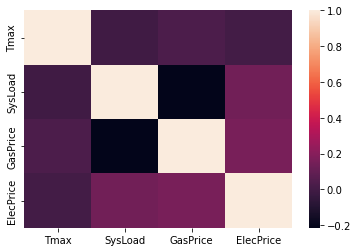

In [40]:
correlation = elect_df.corr()  
sns.heatmap(correlation)

In [41]:
daily_data = elect_df.resample('D').mean()
daily_data.head()


Tmax      SysLoad  GasPrice   ElecPrice
FullDate                                           
2010-09-01  15.8  1731.890833      3.69  114.654167
2010-09-02  15.4  1620.791250      3.69   23.783750
2010-09-03  18.3  1736.073333      4.45   21.040625
2010-09-04  13.7  1484.920208      3.39   20.928125
2010-09-05  14.9  1483.808750      4.45   20.856458

# To find out if this time series is stationary 

In [42]:
from statsmodels.tsa.stattools import adfuller

flattened_data = daily_data.values
flat = flattened_data.flatten()
result = adfuller(flat)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -20.456865
p-value: 0.000000


Because the p value is greater than 0.5 we can say that the data is not stationary. The next step would be to check for seasonality and trend.

<AxesSubplot:xlabel='FullDate'>

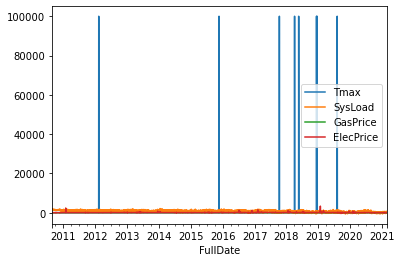

In [43]:
daily_data.plot()

There is no trend here. It is clear that we have a very irregular seasonal occurence here.

<AxesSubplot:xlabel='FullDate'>

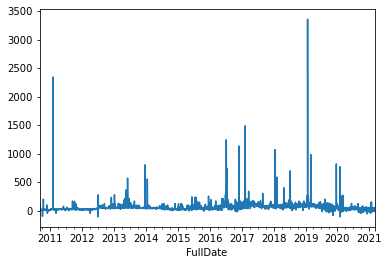

In [44]:
daily_data['ElecPrice'].plot()

In [45]:
Gas_data = daily_data['GasPrice']
result_GasPrice = adfuller(Gas_data)
print('p-value: %f' % result_GasPrice[1])

p-value: 0.045027


In [46]:
'''daily_data = daily_data['SysLoad']
result_SysLoad = adfuller(daily_data)
print('p-value: %f' % result_SysLoad[1])'''

"daily_data = daily_data['SysLoad']\nresult_SysLoad = adfuller(daily_data)\nprint('p-value: %f' % result_SysLoad[1])"

In [47]:
adf_test = adfuller(daily_data.ElecPrice, regression='c', autolag='AIC')
critical_values1 = adf_test[4]
critical_values1_rounded = {key: round(value, 4) for key, value in critical_values1.items()}

adf_test = adfuller(daily_data.GasPrice, regression='c', autolag='AIC')
critical_values2 = adf_test[4]
critical_values2_rounded = {key: round(value, 4) for key, value in critical_values2.items()}

print(critical_values1_rounded, critical_values2_rounded)



{'1%': -3.4321, '5%': -2.8623, '10%': -2.5672} {'1%': -3.4321, '5%': -2.8623, '10%': -2.5672}


In [ ]:
df_1 = daily_data [['FullDate', 'ElecPrice']].copy()
df_1.rename(column={FullDate: 'ds', 'ElecPrice':'y'}, inplace=True)

In [ ]:
# Divide date into train and test sets
train = df_1[:2757]
test = df_1[2757:]

In [ ]:
from prophet import Prophet
# Initialize the model
model = Prophet()

# Fit the model to your training data
predicted = model.fit(train)
forcasted = model.predict(test)


In [ ]:
'''model = Prophet()
model.fit(train[['ds', 'y']])'''

In [ ]:
def mape(test, forecast):
    N = len(test)
    mape = (100/N) * np.sum(np.abs((test - forecast) / test))
    return mape

# Calculate MAPE for the test set
test_actual = test# actual values from the test set
test_forecast = forecast # predicted values from the time series model
mape_result = mape(test_actual, test_forecast)

# Round the result to 2 decimal places
mape_result = round(mape_result, 2)

print("MAPE:", mape_result, "%")
